# Introduction

Fluctuations in brain activity in non-task conditions are now a well-established phenomena in the literature. These fluctuations are not random but shown to exhibit spatial patterns, referred to as resting state networks. Despite being readily identifiable during rest, these networks are related to specific functions and on the other hand abnormalities in such RSNs have been associated with pathology.

In the following, we will demonstrate some starting points for modeling resting state networks in TVB, using the default data set.

# Prerequisites

As this is a tutorial using the TVB library, we first need to import the libraries that we'll use.

In [71]:
%pylab inline
import sys
sys.path.append('scientific_library/')
sys.path.append('tvb_data/')
from tvb.simulator.lab import *
import scipy.stats
from sklearn.decomposition import FastICA
import time
import utils

# Setting up the simulation

In the following, we'll use a basic region level simulation, with the generic oscillator set in an excitable regime, linear coupling with low strength, a stochastic integrator with low noise and a temporal average monitor at 200 Hz.

These settings are a good starting point for modeling resting state patterns because no particular factor dominates the dynamics and a balance between the structural connectivity, moderate intrinsic excitability and noise comes into play.

In [15]:
def run_sim(conn, cs, D, cv=3.0, dt=0.5, simlen=1e3):
    sim = simulator.Simulator(
        model=models.Generic2dOscillator(a=0.0),
        connectivity=conn,
        coupling=coupling.Linear(a=cs),
        integrator=integrators.HeunStochastic(dt=dt, noise=noise.Additive(nsig=array([D]))),
        monitors=monitors.TemporalAverage(period=5.0) # 200 Hz
    )
    sim.configure()
    (t, y), = sim.run(simulation_length=simlen)
    return t, y[:, 0, :, 0]

conn = connectivity.Connectivity(load_default=True)

One of the common features of simulations is an initial transient, so we'll perform a one minute simulation, and as soon as the time series have been generated, we check that the transient has decayed:

In [139]:
tic = time.time()
t, y = run_sim(conn, 6e-2, 5e-4, simlen=10*60e3)
'simulation required %0.3f seconds.' % (time.time() - tic, )

'simulation required 833.346 seconds.'

# Functional Connectivity

Next, to quickly assess the presence of a network structure in the time series, we window the time series into 1 second non overlapping windows, obtain per-window correlation matrices

In [140]:
cs = []
for i in range(int(t[-1]/1e3)):
    cs.append(corrcoef(y[(t>(i*1e3))*(t<(1e3*(i+1)))].T))
cs = array(cs)
cs.shape

(599, 76, 76)

The strength of correlation can be assessed statistically by Fisher Z transforming the coefficients and applying a t-test,

In [141]:
cs_z = arctanh(cs)
for i in range(cs.shape[1]):
    cs_z[:, i, i] = 0.0
_, p = scipy.stats.ttest_1samp(cs, 0.0)

Which we then visualize the structural connectivity (left) and functional connectivity (right) as an adjacency matrices applying a threshold on significance:

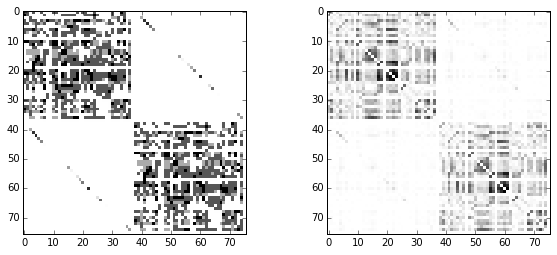

In [142]:
figure(figsize=(10, 4))
subplot(121), imshow(conn.weights, cmap='binary', interpolation='none')
subplot(122), imshow(log10(p)*(p < 0.05), cmap='gray', interpolation='none');

We can then ask what degree of similarity there is between the average functional connectivity and the structural connectivity,

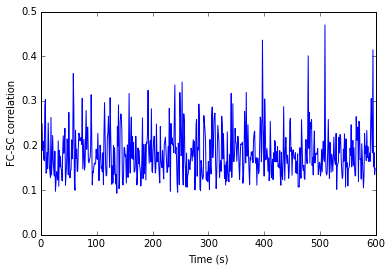

In [144]:
plot(r_[1:len(cs)+1], [corrcoef(cs_i.ravel(), conn.weights.ravel())[0, 1] for cs_i in cs])
ylim([0, 0.5])
ylabel('FC-SC correlation')
xlabel('Time (s)');

which demonstrates fluctuations of FC over time.

# Seed-region correlation maps

A common visualization of FC specific to a given is to pull out its row of the FC matrix and plot a colormap on the anatomy.

In [160]:
def plot_roi_corr_map(reg_name):
    roi = find(conn.ordered_labels==reg_name)[0]
    cs_m = cs[2:].mean(axis=0)
    rm = utils.cortex.region_mapping
    utils.multiview(cs_m[roi][rm], shaded=False, suptitle=reg_name, figsize=(10, 5))

As a few examples of such maps, seeding in the left motor cortex, right ventrolateral prefront cortex, and right superior parietal cortex:

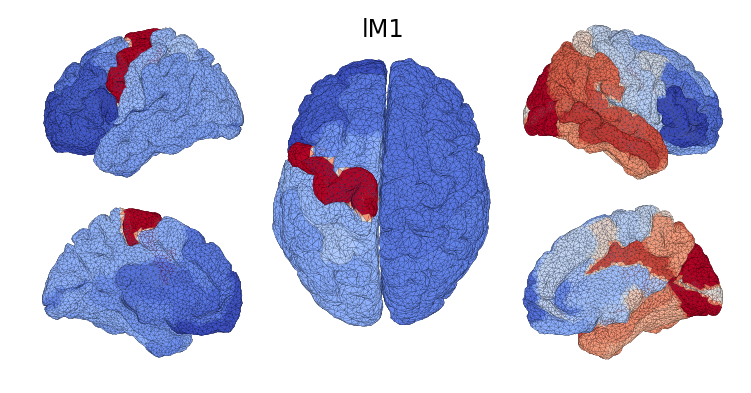

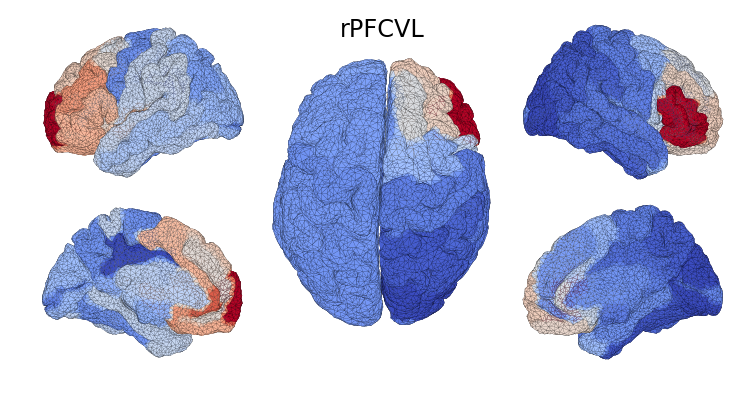

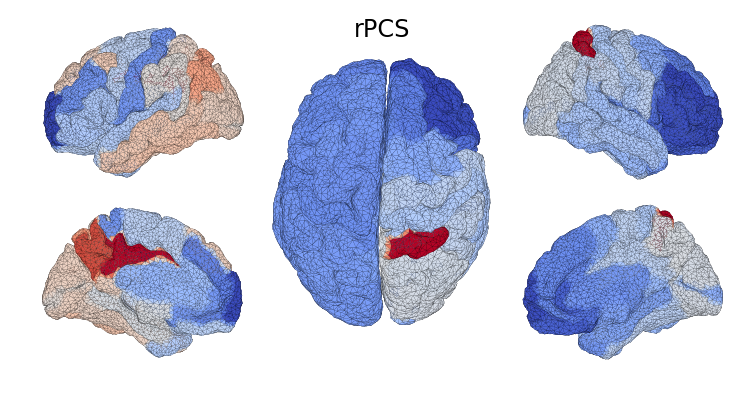

In [162]:
for reg in 'lM1 rPFCVL rPCS'.split():
    plot_roi_corr_map(reg)

Seed-region maps are useful when one has a prior about which regions are implicated for a given network.

# ICA

Another common exploratory tool in resting state data analysis, where the implicated regions or networks are not known a priori, is independent component analysis, which extracts components with unique or independent statistical properties.

For exapmle, we can perform an ICA keeping 5 components the above simulated data,

In [166]:
ica = FastICA(n_components=5, max_iter=250)
ica.fit(y[t>2e3])

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=250,
    n_components=5, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

And then visualize the different components

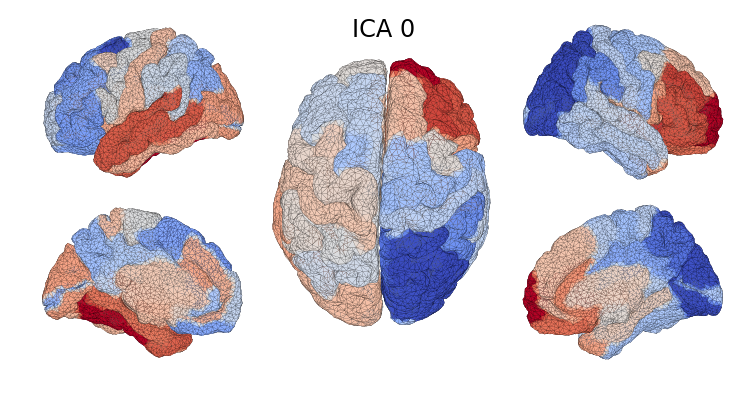

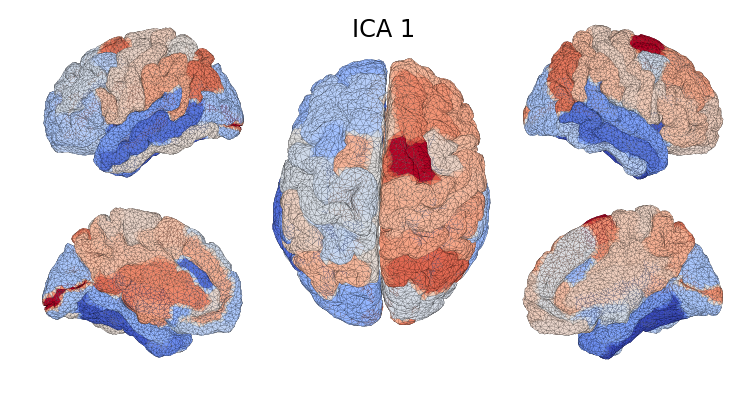

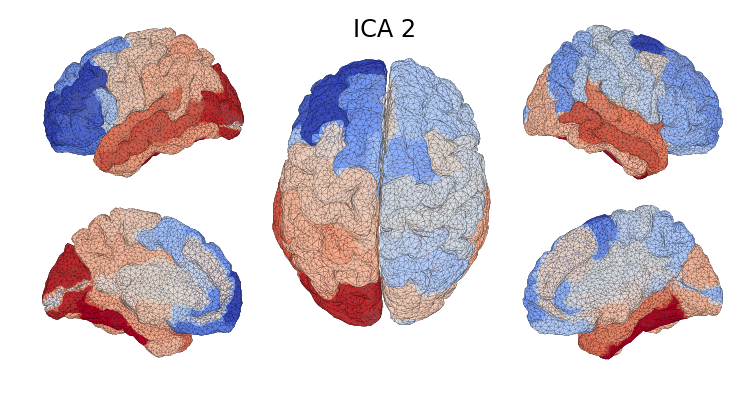

In [171]:
for i, comp in enumerate(ica.components_[:3]):
    utils.multiview(comp[utils.cortex.region_mapping], shaded=False, 
                           suptitle='ICA %d' % (i, ), figsize=(10, 5))

These components are not selected 'by hand', but represent independent subnetworks during the simulated resting state activity.

# Further exploration

These results are starting point, from which you can base you simulations, going in directions such as

- Perform a parameter sweep to identify regions of improved FC-SC correlation
- Introduce a subject specific structural connectivity and compare with subject specific functional connectivity
- Threshold the calculated functional connectivities and apply graph theoretic measures

We hope this has been a useful tutorial and welcome any comments or questions on our mailing list (https://groups.google.com/forum/#!forum/tvb-users) or on our GitHub (https://github.com/the-virtual-brain).

# References

- [Damoiseaux, J. S., Rombouts, S. A. R. B., Barkhof, F., Scheltens, P., Stam, C. J., Smith, S. M., & Beckmann, C. F. (2006). Consistent resting-state networks across healthy subjects. Proceedings of the national academy of sciences, 103(37), 13848-13853.](http://www.pnas.org/content/103/37/13848.full)
- [Mantini, D., Perrucci, M. G., Del Gratta, C., Romani, G. L., & Corbetta, M. (2007). Electrophysiological signatures of resting state networks in the human brain. Proceedings of the National Academy of Sciences, 104(32), 13170-13175](https://www.pnas.org/content/104/32/13170.full)
- [Ghosh, A., Rho, Y., McIntosh, A. R., Kötter, R., & Jirsa, V. K. (2008). Noise during rest enables the exploration of the brain's dynamic repertoire. PLoS Comput Biol, 4(10), e1000196.](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000196)
- [Honey, C. J., Sporns, O., Cammoun, L., Gigandet, X., Thiran, J. P., Meuli, R., & Hagmann, P. (2009). Predicting human resting-state functional connectivity from structural connectivity. Proceedings of the National Academy of Sciences, 106(6), 2035-2040.](https://www.pnas.org/content/106/6/2035.full)
- [Deco, G., & Jirsa, V. K. (2012). Ongoing cortical activity at rest: criticality, multistability, and ghost attractors. The Journal of Neuroscience, 32(10), 3366-3375.](www.jneurosci.org/content/32/10/3366.short)
- [Hansen, E. C., Battaglia, D., Spiegler, A., Deco, G., & Jirsa, V. K. (2015). Functional connectivity dynamics: modeling the switching behavior of the resting state. Neuroimage, 105, 525-535.](http://www.sciencedirect.com/science/article/pii/S1053811914009033)